# GPyTorch Regression Tutorial

## Introduction

In this notebook, we demonstrate many of the design features of GPyTorch using the simplest example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function

$$
\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}
$$

with 100 training examples, and testing on 51 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [1]:
import math
import torch
import numpy as np
import gpytorch
import time
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.manual_seed(7)
np.random.seed(7)

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [54]:
def generate_regressor(x_original, n_regressors):
    """Pad X with zeros from left for #regressors-1 for each data point
    roll over X where window size equals #regressors

    Args:
        x_original (_type_): _description_
        n_regressors (_type_): _description_

    Returns:
        _type_: _description_
    """
    X = []
    x_padded = np.pad(x_original, pad_width=(n_regressors-1, 0), mode="constant", constant_values=(0))
    for _ in range(len(x_original)):
        X.append(x_padded[:n_regressors])
        x_padded = np.roll(x_padded, -1)

    X = np.array(X)

    return X


def load_data(train_in_path, train_out_path, test_in_path, test_out_path, size_train: int, size_test: int, n_regressors: int):
    """_summary_

    Args:
        train_in_path (_type_): _description_
        train_out_path (_type_): _description_
        test_in_path (_type_): _description_
        test_out_path (_type_): _description_
        size (int): _description_
        n_regressors (int): _description_

    Returns:
        _type_: _description_
    """

    x_train_in = np.loadtxt(train_in_path, dtype=float)[:size_train]
    x_test_in = np.loadtxt(test_in_path, dtype=float)[:size_test]

    X_train = generate_regressor(x_train_in, n_regressors)
    X_test = generate_regressor(x_test_in, n_regressors)

    Y_train = np.loadtxt(train_out_path, dtype=float)[:size_train]
    Y_test = np.loadtxt(test_out_path, dtype=float)[:size_test]

    return X_train, Y_train, X_test, Y_test


# Training data is 100 points in [0,1] inclusive regularly spaced
# train_x = torch.linspace(0, 1, 400000000)
# True function is sin(2*pi*x) with Gaussian noise
# train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
# size=100
# train_in_file = "src/data/training/training_input.txt"
# train_out_file = "src/data/training/training_output.txt"
# x = np.loadtxt(train_in_file, dtype=float)[:size]
# train_y = torch.FloatTensor(np.loadtxt(train_out_file, dtype=float)[:size, None])

# # pad X with zeros from left for #regressors-1
# # for each data point roll over X where window size equals #regressors
# n_regressors = 1
# train_x = []
# a = np.pad(x, pad_width=(n_regressors, 0), mode="constant", constant_values=(0))
# for i in range(len(x)):
#     a = np.roll(a, -1)
#     train_x.append(a[:n_regressors])

# train_x = torch.FloatTensor(np.array(train_x))

train_in_file = "src/data/training/training_input.txt"
train_out_file = "src/data/training/training_output.txt"
test_in_file = "src/data/test/test_input.txt"
test_out_file = "src/data/test/test_output.txt"

size_train = 100
size_test = 1000
n_regressors = 5

X_train, Y_train, X_test, Y_test = load_data(
    train_in_file,
    train_out_file,
    test_in_file,
    test_out_file,
    size_train,
    size_test,
    n_regressors,
)

X_train = torch.from_numpy(X_train)[:900]
Y_train = torch.from_numpy(Y_train)[:900]
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

In [55]:
print(X_train.dtype)

torch.float64


## Setting up the model

The next cell demonstrates the most critical features of a user-defined Gaussian process model in GPyTorch. Building a GP model in GPyTorch is different in a number of ways.

First in contrast to many existing GP packages, we do not provide full GP models for the user. Rather, we provide *the tools necessary to quickly construct one*. This is because we believe, analogous to building a neural network in standard PyTorch, it is important to have the flexibility to include whatever components are necessary. As can be seen in more complicated examples, this allows the user great flexibility in designing custom models.

For most GP regression models, you will need to construct the following GPyTorch objects:

1. A **GP Model** (`gpytorch.models.ExactGP`) -  This handles most of the inference.
1. A **Likelihood** (`gpytorch.likelihoods.GaussianLikelihood`) - This is the most common likelihood used for GP regression.
1. A **Mean** - This defines the prior mean of the GP.(If you don't know which mean to use, a `gpytorch.means.ConstantMean()` is a good place to start.)
1. A **Kernel** - This defines the prior covariance of the GP.(If you don't know which kernel to use, a `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` is a good place to start).
1. A **MultivariateNormal** Distribution (`gpytorch.distributions.MultivariateNormal`) - This is the object used to represent multivariate normal distributions.
  
  
### The GP Model
  
The components of a user built (Exact, i.e. non-variational) GP model in GPyTorch are, broadly speaking:

1. An `__init__` method that takes the training data and a likelihood, and constructs whatever objects are necessary for the model's `forward` method. This will most commonly include things like a mean module and a kernel module.

2. A `forward` method that takes in some $n \times d$ data `x` and returns a `MultivariateNormal` with the *prior* mean and covariance evaluated at `x`. In other words, we return the vector $\mu(x)$ and the $n \times n$ matrix $K_{xx}$ representing the prior mean and covariance matrix of the GP. 

This specification leaves a large amount of flexibility when defining a model. For example, to compose two kernels via addition, you can either add the kernel modules directly:

```python
self.covar_module = ScaleKernel(RBFKernel() + LinearKernel())
```

Or you can add the outputs of the kernel in the forward method:

```python
covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)
```


### The likelihood

The simplest likelihood for regression is the `gpytorch.likelihoods.GaussianLikelihood`. This assumes a homoskedastic noise model (i.e. all inputs have the same observational noise).

There are other options for exact GP regression, such as the [FixedNoiseGaussianLikelihood](http://docs.gpytorch.ai/likelihoods.html#fixednoisegaussianlikelihood), which assigns a different observed noise value to different training inputs.

In [56]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        self.covar_module.base_kernel.lengthscale = 1.0
        self.covar_module.outputscale = 1.0
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# print(torch.get_num_threads())
# print(torch.get_num_interop_threads() )
# torch.set_num_threads(2)
likelihood = gpytorch.likelihoods.GaussianLikelihood()#noise_prior=gpytorch.priors.NormalPrior(0, 1), lambda module: module.noise.sqrt()) # GaussianLikelihood() torch.ones(X_train.shape)
model = ExactGPModel(X_train, Y_train, likelihood)
likelihood.noise = 0.1
# model.covar_module.base_kernel.raw_lengthscale = torch.nn.Parameter(torch.tensor([1.0]))
# model.covar_module.outputscale = 1.
# model.likelihood.noise_covar.raw_noise = torch.nn.Parameter(torch.tensor([0.1]))
#model.likelihood.noise_covar.register_prior("noise_std_prior", gpytorch.priors.NormalPrior(0, 1), lambda module: module.noise.sqrt())

In [57]:
print(f'Actual noise value: {likelihood.noise}')
print(f'Noise constraint: {likelihood.noise_covar.raw_noise_constraint}')

Actual noise value: tensor([0.1000], grad_fn=<AddBackward0>)
Noise constraint: GreaterThan(1.000E-04)


In [58]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = -2.2532198429107666
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.5413248538970947
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.5413248538970947


In [60]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # observed_pred = likelihood(model(X_test))
    f_pred = model(X_test)
    
    # y_pred = likelihood(model(X_test), noise=(torch.ones(X_test.shape) * 0.1))
    # y_mean = y_pred.mean
print(f_pred.mean[-5:])

tensor([-0.0100, -0.0100, -0.0100, -0.0100, -0.0100], dtype=torch.float64)


In [53]:
hpx_pred_file = "/home/maksim/simtech/thesis/GPPPy_hpx/build/predictions.txt"
hpx_pred = np.loadtxt(hpx_pred_file, dtype=float)[:size_test, None]
print(hpx_pred[:5])

[[-1.79724 ]
 [-1.57972 ]
 [-1.10917 ]
 [-0.457993]
 [ 0.874913]]


In [18]:
# runtimes = []
# threads = [1] + [t for t in range(2, 6, 2)]
# for t in threads:
#     model.train()
#     likelihood.train()
#     torch.set_num_threads(t)
#     print(torch.get_num_threads())
#     start = time.time()
#     model(train_x)
#     print(time.time() - start)
# ... plotting (threads, runtimes) ...



### Model modes

Like most PyTorch modules, the `ExactGP` has a `.train()` and `.eval()` mode.
- `.train()` mode is for optimizing model hyperameters.
- `.eval()` mode is for computing predictions through the model posterior.

## Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from `torch.optim`, and all trainable parameters of the model should be of type `torch.nn.Parameter`. Because GP models directly extend `torch.nn.Module`, calls to methods like `model.parameters()` or `model.named_parameters()` function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients
2. Call the model and compute the loss
3. Call backward on the loss to fill in gradients
4. Take a step on the optimizer

However, defining custom training loops allows for greater flexibility. For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters (which may be useful in deep kernel learning for example).

1.32 (4, 8) 50 iter

34.6 (8, 8) 20 iter 10.000
34.1 (8, 8) 20 iter
34.8 (8, 8) 20 iter
35.9 (4, 4) 20 iter
36.6 (4, 8) 20 iter
36.8 (4, 8) 20 iter
52.5 (2, 8) 20 iter
50.8 (2, 8) 20 iter
50.6 (2, 8) 20 iter
50.1 (2, 8) 20 iter
1 min 18.3 (1, 8) 20 iter
1 min 18.6 (1, 8) 20 iter

1 min 50.5 (2, 8) 10 iter 20.000
1 min 49.1 (2, 8)
1 min 21.6 (4, 8) 
1 min 18.9 (4, 8)
1 min 20.5 (4 ,8)
1 min 20.8 (4, 8)
1 min 18.0 (6, 8)
1 min 17.5 (6, 8)
1 min 15.7 (8, 8)
1 min 15.6 (8, 8)

2.1523

In [164]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 10 #50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -(mll(output, Y_train))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/10 - Loss: 2.655   lengthscale: 1.313   noise: 0.744
Iter 2/10 - Loss: 2.560   lengthscale: 1.313   noise: 0.798
Iter 3/10 - Loss: 2.476   lengthscale: 1.313   noise: 0.854
Iter 4/10 - Loss: 2.403   lengthscale: 1.313   noise: 0.912
Iter 5/10 - Loss: 2.338   lengthscale: 1.313   noise: 0.972
Iter 6/10 - Loss: 2.283   lengthscale: 1.313   noise: 1.032
Iter 7/10 - Loss: 2.235   lengthscale: 1.313   noise: 1.094
Iter 8/10 - Loss: 2.194   lengthscale: 1.313   noise: 1.157
Iter 9/10 - Loss: 2.158   lengthscale: 1.313   noise: 1.219
Iter 10/10 - Loss: 2.127   lengthscale: 1.313   noise: 1.282


## Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

Just as a user defined GP model returns a `MultivariateNormal` containing the prior mean and covariance from forward, a trained GP model in eval mode returns a `MultivariateNormal` containing the posterior mean and covariance.

If we denote a test point (`test_x`) as `x*` with the true output being `y*`, then `model(test_x)` returns the model posterior distribution `p(f* | x*, X, y)`, for training data `X, y`. This posterior is the distribution over the function we are trying to model, and thus quantifies our model uncertainty.

In contrast, `likelihood(model(test_x))` gives us the posterior predictive distribution `p(y* | x*, X, y)` which is the probability distribution over the predicted output value. Recall in our problem setup 

$$
\begin{align}
y &= \sin(2\pi x) + \epsilon
\end{align}
$$

where 𝜖 is the likelihood noise for each observation. By including the _likelihood noise_ which is the noise in your observation (e.g. due to noisy sensor), the prediction is over the observed value of the test point.

Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
```

The `gpytorch.settings.fast_pred_var` context is not needed, but here we are giving a preview of using one of our cool features, getting faster predictive distributions using [LOVE](https://arxiv.org/abs/1803.06058).

In [23]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

## Plot the model fit

In the next cell, we plot the mean and confidence region of the Gaussian process model. The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

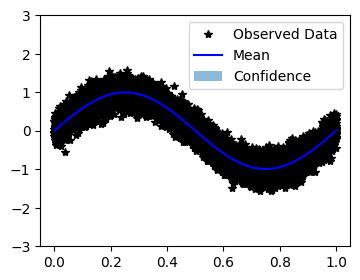

In [24]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])